## Imports

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten ,MaxPooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import re

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
K.clear_session()

## Functions

In [2]:
# extract prefix to group by participant insted of trip
def extract_prefix(filename):
    # split filename on '_' 
    return re.split(r'_', filename)[0]

# create sequences of consecutive intrevales 
def create_sequences(data, labels, filenames, window_size):
    # vars to store the sequences and the respective labels
    sequences = []
    sequence_labels = []
    
    # get the file name to filter by participant
    current_prefix = extract_prefix(filenames[0])
    current_sequence = []
    current_labels = []
    
    # loop all intrevals
    for i in range(len(data)):
        # get current filename
        prefix = extract_prefix(filenames[i])
        
        # if the intreval belongs to diferent participant reset the sequences and vars
        if prefix != current_prefix:
            current_prefix = prefix
            current_sequence = [] 
            current_labels = []

        # add the intrevlal and the label to the current sequence
        current_sequence.append(data[i])
        current_labels.append(labels[i])
        
        # check if the sequence reach the max size and if so, store the sequence and the lable
        if len(current_sequence) == window_size:
            sequences.append(current_sequence.copy()) 
            sequence_labels.append(current_labels[-1]) 
            current_sequence.pop(0)

    return np.array(sequences), np.array(sequence_labels)

## Data Pre-Processing

In [3]:
# get data
file_path_1 = '../pre_process_2/datasets_v2/supervised_1_min.csv'

df_1_min = pd.read_csv(file_path_1, delimiter=',')


# filenames with the "pvt recording"
filenames_to_remove = [
    "fp01_2.edf", "fp01_4.edf", "fp02_1.edf", "fp02_2.edf", "fp02_4.edf",
    "fp03_1.edf", "fp03_2.edf", "fp04_1.edf", "fp05_1.edf", "fp06_1.edf",
    "fp07_1.edf", "fp08_1.edf", "fp09_1.edf", "fp10_1.edf", "fp11_1.edf",
    "fp12_1.edf", "fp13_1.edf", "fp14_1.edf", "fp14_3.edf", "fp15_1.edf",
    "fp16_1.edf", "fp17_1.edf", "fp17_2.edf", "fp17_4.edf", "fp18_1.edf",
    "fp18_2.edf", "fp19_1.edf", "fp19_3.edf", "fp19_4.edf", "fp20_1.edf", 
    "fp20_3.edf"
]

# remove the unwanted instances from the dfs
df_1_min = df_1_min[~df_1_min['Filename'].isin(filenames_to_remove)]

# remove columns with null values
df_1_min = df_1_min[(df_1_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]

# remove missing values
df_1_min = df_1_min.dropna()

# get wanted features for training data
df_features_1_min = df_1_min[(df_1_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]

# final wanted features
features_1_min = df_features_1_min.columns.to_list()

### Normalization

In [ ]:
# normalize data
scaler = StandardScaler()
X_scaled_1_min = scaler.fit_transform(df_1_min[features_1_min].values)

### Descretrization

In [5]:
# descretize the value of KSS
labels_1_min = (df_1_min['kss_answer'] > 6).astype(int)

### Prepare data to train the model

In [6]:
# get all filenames
filenames_1_min = df_1_min['Filename'].values

# number of intrevlas in sequence
window_size = 10

# create sequences and respective lables
X_sequences_1_min, y_sequences_1_min = create_sequences(X_scaled_1_min, labels_1_min.values, filenames_1_min, window_size)

# Verify shape of sequences
print("Shape of X_sequences of 1 Min :", X_sequences_1_min.shape)
print("Shape of y_sequences of 1 Min:", X_sequences_1_min.shape)

# test and train data split
X_train_1_min_no_sec, X_test_1_min_no_sec, y_train_1_min_no_sec, y_test_1_min_no_sec = train_test_split(X_scaled_1_min, labels_1_min, test_size=0.20, random_state=42)
X_train_1_min, X_test_1_min, y_train_1_min, y_test_1_min = train_test_split(X_sequences_1_min, y_sequences_1_min, test_size=0.20, random_state=42)

Shape of X_sequences of 1 Min : (4174, 10, 27)
Shape of y_sequences of 1 Min: (4174, 10, 27)


### Create LSTM Models

In [11]:
# Clear the current session to reset the model and optimizer state
K.clear_session()

# define NN model for 1 min
nn_model_1_min = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_dim=X_train_1_min_no_sec.shape[1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# compile the model
optimizer = Adam(learning_rate=0.001)
nn_model_1_min.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# define CNN model for 1 min
cnn_model_1_min = Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_1_min.shape[1], X_train_1_min.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2), 

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2), 

    tf.keras.layers.Dense(1, activation='sigmoid') 
])

# compile the model
cnn_model_1_min.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define LSTM Model for 1 min
lstm_model_1_min = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train_1_min.shape[1], X_train_1_min.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model_1_min.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Models Training

In [12]:
# train models
history_nn = nn_model_1_min.fit(X_train_1_min_no_sec, y_train_1_min_no_sec, epochs=200, batch_size=32, validation_split=0.2)
history_cnn = cnn_model_1_min.fit(X_train_1_min, y_train_1_min, epochs=200, batch_size=32, validation_split=0.2)
history_lstm = lstm_model_1_min.fit(X_train_1_min, y_train_1_min, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5279 - loss: 0.7085 - val_accuracy: 0.6135 - val_loss: 0.6711
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.5865 - loss: 0.6760 - val_accuracy: 0.6264 - val_loss: 0.6572
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.6006 - loss: 0.6657 - val_accuracy: 0.6336 - val_loss: 0.6484
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.6249 - loss: 0.6455 - val_accuracy: 0.6408 - val_loss: 0.6415
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.6165 - loss: 0.6400 - val_accuracy: 0.6408 - val_loss: 0.6379
Epoch 6/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.6158 - loss: 0.6473 - val_accuracy: 0.6537 - val_loss: 0.6306
Epoch 7/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.6258 - loss: 0.6306 - val_accuracy: 0.6451 - val_loss: 0.6315
Epoch 8/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.6298 - loss: 0.6246 - val_accura

### Evaluation and Visualization

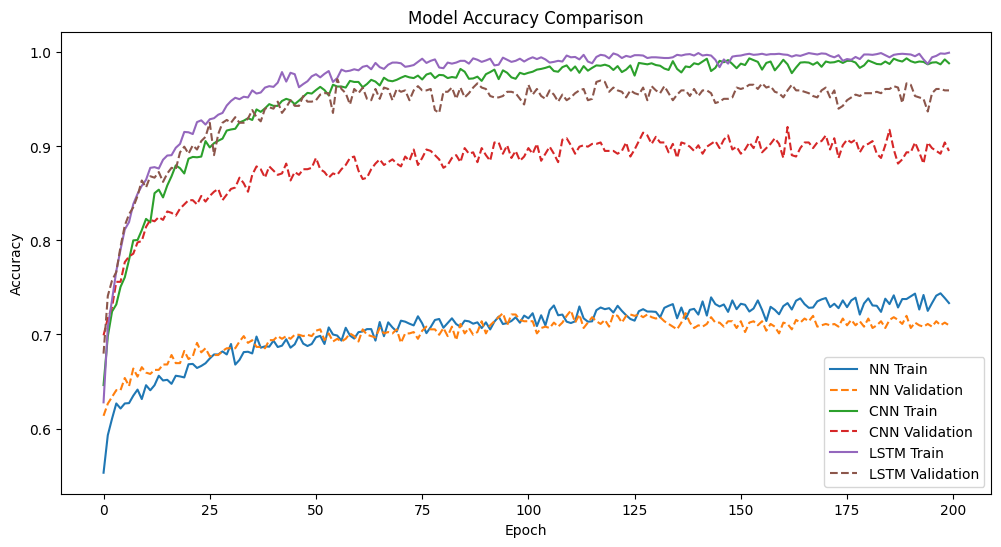

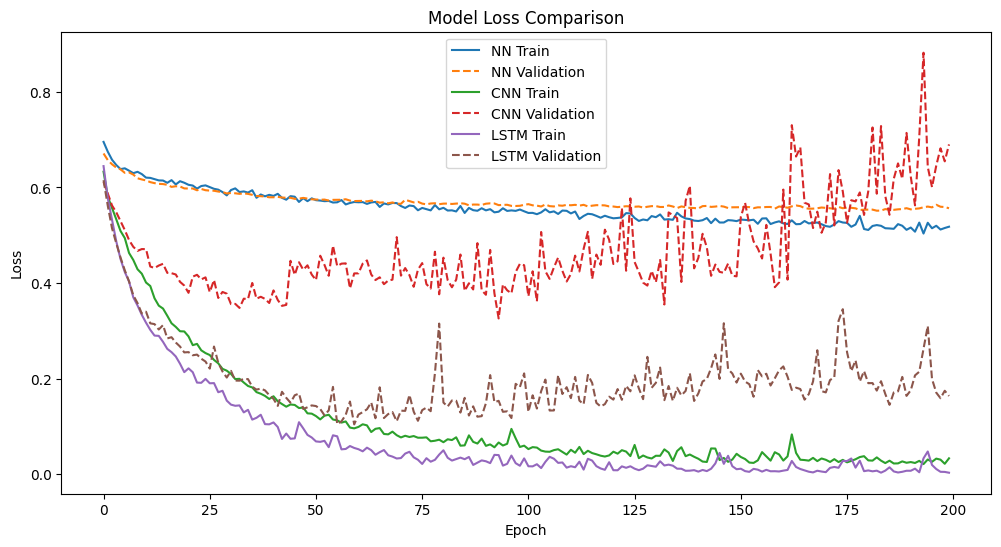

In [13]:
# all histories and model 
histories = [history_nn, history_cnn, history_lstm]
model_names = ['NN', 'CNN', 'LSTM']

# plot accuracy for all models
plt.figure(figsize=(12, 6))
for history, name in zip(histories, model_names):
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Validation', linestyle='--')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# plot loss for all models
plt.figure(figsize=(12, 6))
for history, name in zip(histories, model_names):
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], label=f'{name} Validation', linestyle='--')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## Models Predictions

### ROC Curve

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
Final Test Predictions Results for NN:
  Accuracy: 0.715
  Precision: 0.679
  Recall: 0.736
  F1 Score: 0.706
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Final Test Predictions Results for CNN:
  Accuracy: 0.884
  Precision: 0.894
  Recall: 0.871
  F1 Score: 0.882
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Final Test Predictions Results for LSTM:
  Accuracy: 0.952
  Precision: 0.956
  Recall: 0.947
  F1 Score: 0.952


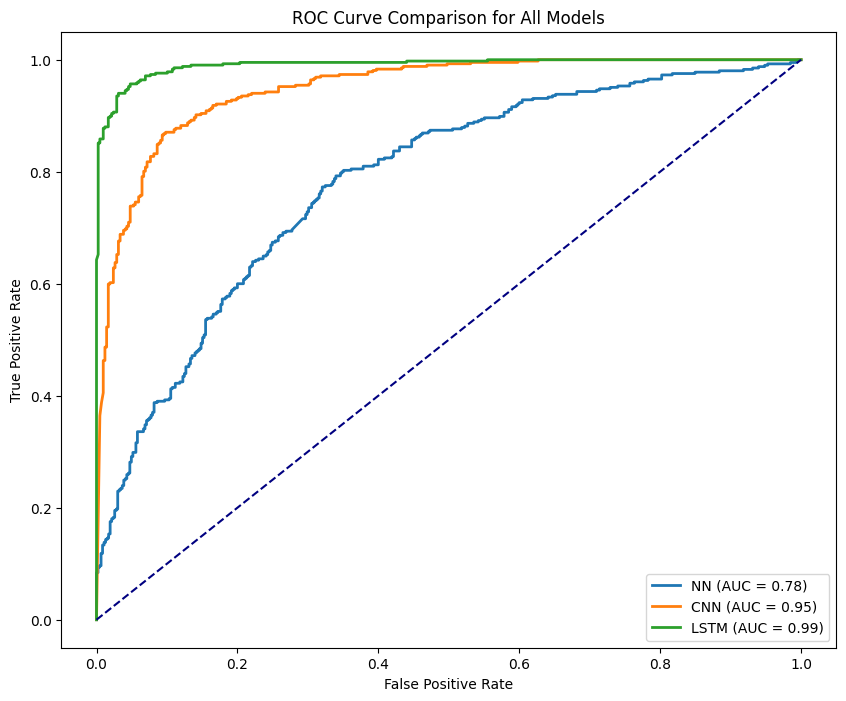

In [14]:
# models, test data, and names
models = [nn_model_1_min, cnn_model_1_min, lstm_model_1_min]
X_tests = [X_test_1_min_no_sec, X_test_1_min, X_test_1_min]
y_tests = [y_test_1_min_no_sec, y_test_1_min, y_test_1_min]
model_names = ['NN', 'CNN', 'LSTM']

# store results
all_metrics = []

# ROC plot setup
plt.figure(figsize=(10, 8))

for model, X_test, y_test, name in zip(models, X_tests, y_tests, model_names):
    # make predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)  # threshold and reshape to binary

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    
    # append metrics results
    all_metrics.append((name, accuracy, precision, recall, f1))
    
    # print results for the model
    print(f"Final Test Predictions Results for {name}:")
    print(f'  Accuracy: {accuracy:.3f}')
    print(f'  Precision: {precision:.3f}')
    print(f'  Recall: {recall:.3f}')
    print(f'  F1 Score: {f1:.3f}')
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# plot all ROC curves together
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for All Models')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


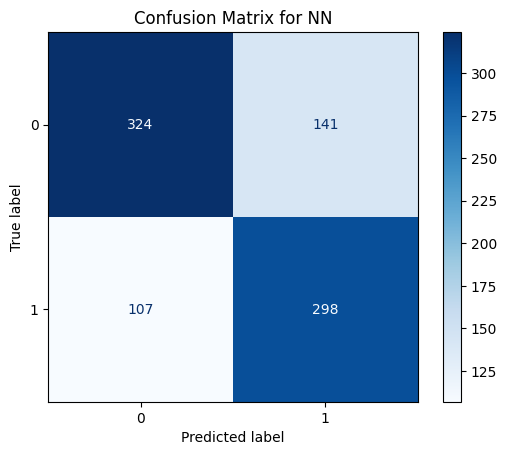

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


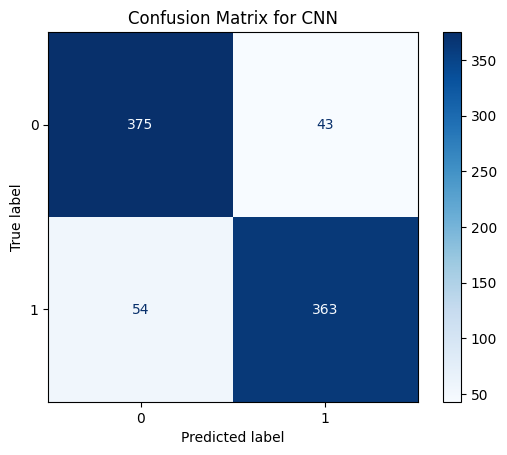

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


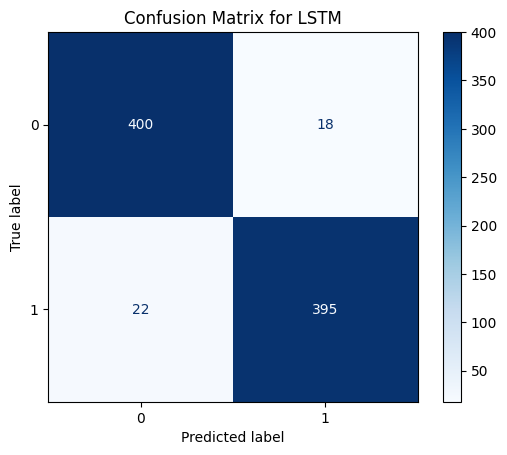

In [15]:
# CM
for model, X_test, y_test, name in zip(models, X_tests, y_tests, model_names):
    y_pred_binary = (model.predict(X_test) > 0.5).astype(int).reshape(-1)
    cm = confusion_matrix(y_test, y_pred_binary)
    
    # plot CM
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

### Evaluation Resume


Summary of Evaluation Metrics for All Models:
NN: Accuracy=0.715, Precision=0.679, Recall=0.736, F1 Score=0.706
CNN: Accuracy=0.884, Precision=0.894, Recall=0.871, F1 Score=0.882
LSTM: Accuracy=0.952, Precision=0.956, Recall=0.947, F1 Score=0.952


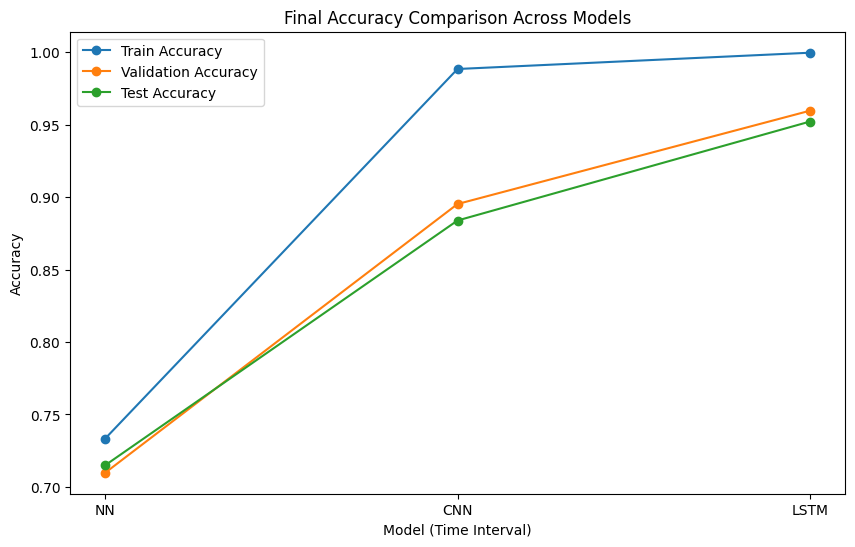

In [ ]:
# models evaluation
print("\nSummary of Evaluation Metrics for All Models:")
for name, accuracy, precision, recall, f1 in all_metrics:
    print(f'{name}: Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1 Score={f1:.3f}')


# training and validation accuracies for each model
final_train_accuracies = [history.history['accuracy'][-1] for history in histories]
final_val_accuracies = [history.history['val_accuracy'][-1] for history in histories]

# Extract test accuracies from all_metrics
final_test_accuracies = [metric[1] for metric in all_metrics]  # accuracy is the second element in each tuple in all_metrics

# plot all accuracies
plt.figure(figsize=(10, 6))
plt.plot(model_names, final_train_accuracies, marker='o', label='Train Accuracy')
plt.plot(model_names, final_val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(model_names, final_test_accuracies, marker='o', label='Test Accuracy')
plt.title('Final Accuracy Comparison Across Models')
plt.xlabel('Model (Time Interval)')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()